# Toying with the idea of creating a genetic algorithm to fit a multi variable curve

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt

## Creating a dataset to play with 

### First get some parameters for the whole simulation

In [2]:
num_sinusoids = 10
population_size = 500
num_generations = 2000
save_every = 100 # how often to save history

Text(0, 0.5, 'singal (arb. units)')

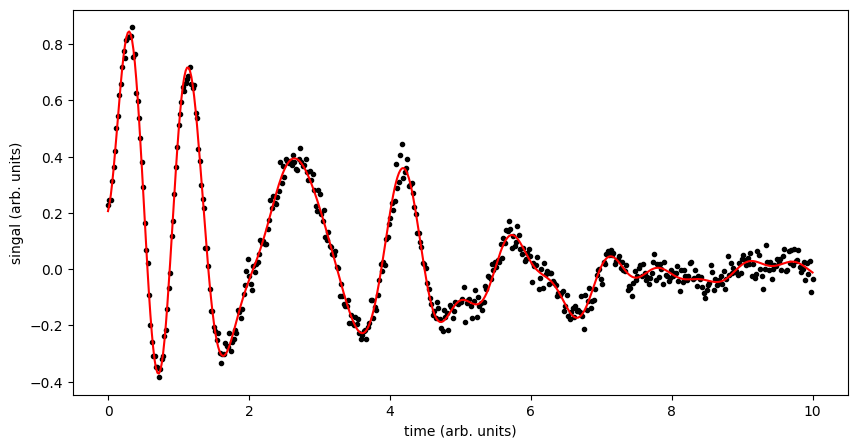

In [3]:
#Creating a dampened sine wave with several components components
rng = np.random.default_rng(seed=42)
sin_coeffs = rng.random(num_sinusoids) - 0.5
sin_freqs = rng.random(num_sinusoids)  * 10
sin_phases = rng.random(num_sinusoids) * 2.0 * np.pi

dampening_coeffs = (rng.random(num_sinusoids) )*7
time = np.linspace(0, num_sinusoids, 500)


## Create the signal I want to use as my "data" to fit
signal = np.sum([c * np.sin(f * time+ p)* np.exp(-time / d) for c, f, p, d in zip(sin_coeffs, sin_freqs, sin_phases, dampening_coeffs)], axis=0) 
noise = rng.standard_normal(len(time))  * 0.03
signal_w_noise = signal + noise 


plt.figure(figsize=(10, 5))
plt.plot(time, signal_w_noise, '.', color='k')
plt.plot(time, signal, color='r')

plt.xlabel('time (arb. units)')
plt.ylabel('singal (arb. units)')



In [4]:
# Creating initial population of candidate solutions

#First create one single individual to check that everythong is working fine
single_individual_amps = rng.random((1, num_sinusoids)) - 0.5
single_individual_freqs = rng.random((1, num_sinusoids)) * 10
single_individual_phases = rng.random((1, num_sinusoids)) * 2.0 * np.pi 
single_individual_dampenings = rng.random((1, num_sinusoids))*10
singe_individual_params = np.asarray([single_individual_amps, single_individual_freqs, single_individual_phases, single_individual_dampenings])

# Now create the full population
population_amps = rng.random((population_size, num_sinusoids)) - 0.5
population_freqs = rng.random((population_size, num_sinusoids)) * 10
population_phases = rng.random((population_size, num_sinusoids)) * 2.0 * np.pi 
population_dampenings = rng.random((population_size, num_sinusoids))*10
population_params = np.asarray([population_amps, population_freqs, population_phases, population_dampenings])


## Creating the functions the main loop will use

In [5]:
def generate_signals(params, time):
    amps = params[0,:,:]
    freqs = params[1,:,:]
    phases = params[2,:,:]
    dampenings = params[3,:,:]

    signals = (amps[:,:,np.newaxis] * np.sin((freqs[:,:,np.newaxis] * time) + 
                                             phases[:,:,np.newaxis])* np.exp(-time / dampenings[:,:,np.newaxis]) ).sum(axis=1)
    return signals
signals = generate_signals(population_params, time)


def fitness_function(signals, target_signal):
    # Calculate fitness as the negative mean squared error between generated signals and target signal
    fitness = -np.mean((signals - target_signal[np.newaxis, :])**2, axis=1)
    return fitness
fitness_scores = fitness_function(signals, signal_w_noise)

# # Crossover and Selection
def create_next_generation(population_params, fitness_scores, population_size, rng, mutation_rate=0.1, elitism=0.1):

    # Rank individuals based on fitness scores
    index_order = np.argsort(fitness_scores)

    # Select the top 50% individuals
    num_selected = population_size // 2

    selected_indices = index_order[-num_selected:]
    selected_population = population_params[:, selected_indices, :]

    # Create offspring from pairs of selected individuals
    nb_children = population_size - num_selected
    parents = selected_population[:, np.random.choice(num_selected, (nb_children,2), replace=True), :] # paris of parents for each son
    all_children = rng.permuted(parents, axis=2)
    all_children = np.concatenate([all_children[:,:,0,:],all_children[:,:,1,:]], axis=1)

    # Apply elitism before mutation
    numb_selected_elite = int(population_size*elitism)
    selected_idxs_elite = index_order[-numb_selected_elite:]
    all_children[:, selected_idxs_elite, :] = population_params[:, selected_idxs_elite, :]


    # create mutations for everyone
    all_mutations_amps = all_children[0] + (rng.random(all_children[0].shape)-0.5)
    all_mutations_freqs = np.abs(all_children[1] + ((rng.random(all_children[1].shape)-0.5)*10))
    all_mutations_phases = np.mod( (all_children[2] + ((rng.random(all_children[2].shape)-0.5)* 2.0 * np.pi )), 2.0 * np.pi )
    all_mutations_dampenings = np.abs(all_children[3] + ((rng.random(all_children[3].shape)-0.5)*10))
    all_mutations = np.asarray([all_mutations_amps, all_mutations_freqs, all_mutations_phases,all_mutations_dampenings])

    # select the % of the population's genes to mutate 
    mutation_mask = rng.random(all_children.shape) < mutation_rate
    all_children[mutation_mask] = all_mutations[mutation_mask]

    return all_children
next_gen = create_next_generation(population_params, fitness_scores, population_size, rng, mutation_rate=0.1)



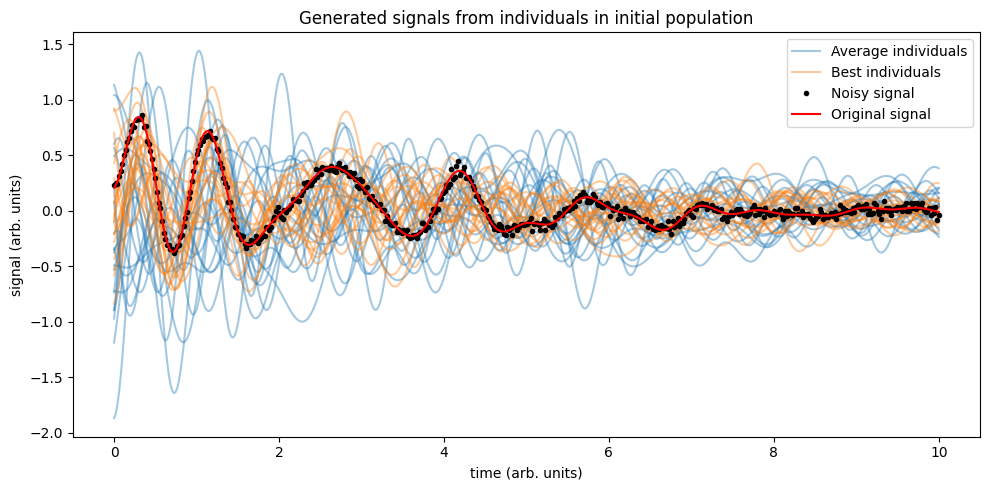

In [6]:
# Check the generate signals function produces the same results as before
index_order = np.argsort(fitness_scores)
ordered_pop_params = population_params[:, index_order, :]
best_signals_ordered = generate_signals(ordered_pop_params, time)


# Slice controls for the two groups
c1_slice = slice(int(population_size/2)-10, int(population_size/2)+10)
c2_slice = slice(-20, None)

plt.figure(figsize=(10, 5))

# Plot a single labeled line per color, then the rest without legend entries
c1_group = best_signals_ordered[c1_slice]
c2_group = best_signals_ordered[c2_slice]

if c1_group.shape[0] > 0:
    plt.plot(time, c1_group[0].T, c='C0', alpha=0.4, label='Average individuals')
    if c1_group.shape[0] > 1:
        plt.plot(time, c1_group[1:].T, c='C0', alpha=0.4, label='_nolegend_')

if c2_group.shape[0] > 0:
    plt.plot(time, c2_group[0].T, c='C1', alpha=0.4, label='Best individuals')
    if c2_group.shape[0] > 1:
        plt.plot(time, c2_group[1:].T, c='C1', alpha=0.4, label='_nolegend_')

plt.plot(time, signal_w_noise, '.', color='k', alpha=1, label='Noisy signal')
plt.plot(time, signal, color='r', label='Original signal')

plt.xlabel('time (arb. units)')
plt.ylabel('signal (arb. units)')
plt.title('Generated signals from individuals in initial population')
plt.legend()
plt.tight_layout()

## Main loop

In [7]:
## Main loop of the genetic algorithm


population_params_history = [population_params]
signals_history = [signals]
fitness_history = [fitness_scores]

signals_tmp = copy.copy(signals)
fitness_scores_tmp = copy.copy(fitness_scores)
population_params_tmp = copy.copy(population_params)

for generation in range(num_generations):

    signals_tmp = generate_signals(population_params_tmp, time)
    fitness_scores_tmp = fitness_function(signals_tmp, signal_w_noise)
    population_params_tmp = create_next_generation(population_params_tmp, fitness_scores_tmp, population_size, rng, mutation_rate=0.01, elitism=0.2)

    if generation % save_every == 0: # Every 10 generations, store the history
        population_params_history.append(population_params_tmp)
        signals_history.append(signals_tmp)
        fitness_history.append(fitness_scores_tmp)

population_params_history =  np.asarray(population_params_history)
signals_history = np.asarray(signals_history)
fitness_history = np.asarray(fitness_history)


# Analyse simulation results

In [8]:
early_gen = 0   #example of what the first generations look like    
mid_gen = 10    # what the mid generation (not fully optimized) should look like
last_gen = -1   # what the last, fully optimized, generation look like


first_gen_sorted = np.argsort(fitness_history[early_gen])
mid_gen_sorted = np.argsort(fitness_history[mid_gen])
last_gen_sorted = np.argsort(fitness_history[last_gen])



best_20_firstgen_idx = first_gen_sorted[-50:]
best_20_midgen_idx = mid_gen_sorted[-50:]
best_20_lastgen_idx = last_gen_sorted[-50:] 

worst_20_firstgen_idx = first_gen_sorted[0:50]
best_20_firstgen_idx = first_gen_sorted[-50:]

worst_20_lastgen_idx = last_gen_sorted[0:50]
best_20_lastgen_idx = last_gen_sorted[-50:]


first_gen_signals = signals_history[early_gen]
first_gen_signals_sorted = first_gen_signals[first_gen_sorted]

mid_gen_signals = signals_history[mid_gen]
mid_gen_signals_sorted = mid_gen_signals[mid_gen_sorted]

last_gen_signals = signals_history[last_gen]
last_gen_signals_sorted = last_gen_signals[last_gen_sorted]

Text(0.5, 1.0, 'Fitness evolution over generations')

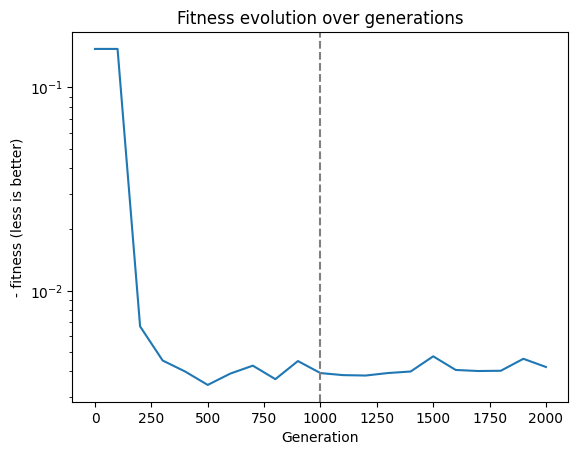

In [9]:
fig, axs = plt.subplots(1)
axs.plot(np.arange(len(fitness_history.mean(axis=1)))*save_every, -fitness_history.mean(axis=1) )
axs.set_yscale('log')
axs.set_xlabel('Generation')
axs.set_ylabel('- fitness (less is better)')
axs.axvline(x=mid_gen*save_every, color='gray', linestyle='--', label='Mid Generation')
axs.set_title('Fitness evolution over generations')

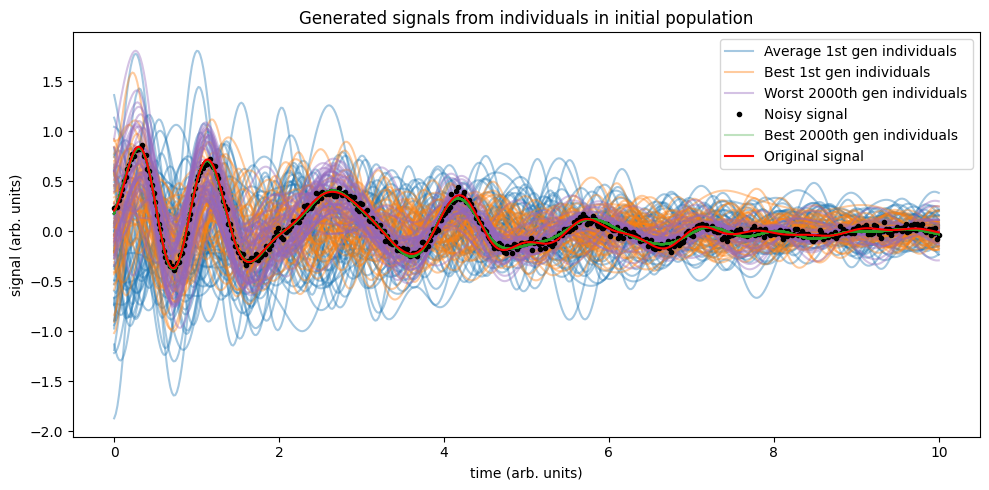

In [10]:
# Slice controls for the two groups
c1_slice = slice(int(population_size/2)-25, int(population_size/2)+25)
c2_slice = slice(-50, None)
c3_slice = slice(0, 50)

plt.figure(figsize=(10, 5))

first_gen_signals_group1 = first_gen_signals_sorted[c1_slice]
first_gen_signals_group2 = first_gen_signals_sorted[c2_slice]

last_gen_signals_group1 = last_gen_signals_sorted[c1_slice]
# last_gen_signals_group2 = last_gen_signals_sorted[c2_slice]
last_gen_signals_group3 = last_gen_signals_sorted[c3_slice]

if first_gen_signals_group1.shape[0] > 0:
    plt.plot(time, first_gen_signals_group1[0].T, c='C0', alpha=0.4, label='Average 1st gen individuals')
    if first_gen_signals_group1.shape[0] > 1:
        plt.plot(time, first_gen_signals_group1[1:].T, c='C0', alpha=0.4, label='_nolegend_')

if first_gen_signals_group2.shape[0] > 0:
    plt.plot(time, first_gen_signals_group2[0].T, c='C1', alpha=0.4, label='Best 1st gen individuals')
    if first_gen_signals_group2.shape[0] > 1:
        plt.plot(time, first_gen_signals_group2[1:].T, c='C1', alpha=0.4, label='_nolegend_')



if last_gen_signals_group3.shape[0] > 0:
    plt.plot(time, last_gen_signals_group3[0].T, c='C4', alpha=0.4, label=f'Worst {num_generations}th gen individuals')
    if last_gen_signals_group3.shape[0] > 1:
        plt.plot(time, last_gen_signals_group3[1:].T, c='C4', alpha=0.4, label='_nolegend_')

plt.plot(time, signal_w_noise, '.', color='k', alpha=1, label='Noisy signal')

if last_gen_signals_group1.shape[0] > 0:
    plt.plot(time, last_gen_signals_group1[0].T, c='C2', alpha=0.3, label=f'Best {num_generations}th gen individuals')
    if last_gen_signals_group1.shape[0] > 1:
        plt.plot(time, last_gen_signals_group1[1:].T, c='C2', alpha=0.3, label='_nolegend_')


plt.plot(time, signal, color='r', label='Original signal')

plt.xlabel('time (arb. units)')
plt.ylabel('signal (arb. units)')
plt.title('Generated signals from individuals in initial population')
plt.legend()
plt.tight_layout()

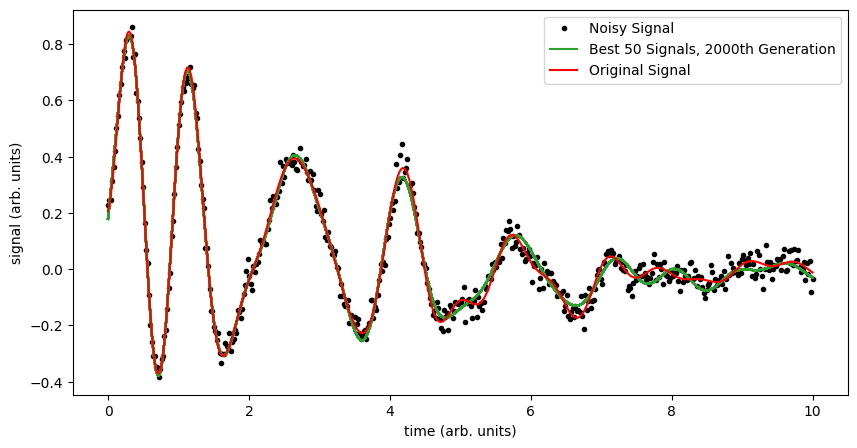

In [11]:
plt.figure(figsize=(10, 5))

plt.plot(time, signal_w_noise, '.', color='k', label='Noisy Signal' )

plt.plot(time, last_gen_signals[last_gen_sorted[-1:]].T, color = 'C2', alpha = 1, label=f'Best 50 Signals, {num_generations}th Generation')
plt.plot(time, last_gen_signals[last_gen_sorted[-50:]].T, color = 'C2', alpha = 1, ) 

plt.plot(time, signal, color = 'r', ls='-', label='Original Signal')

plt.xlabel('time (arb. units)')
plt.ylabel('signal (arb. units)')

plt.legend()
plt.show()

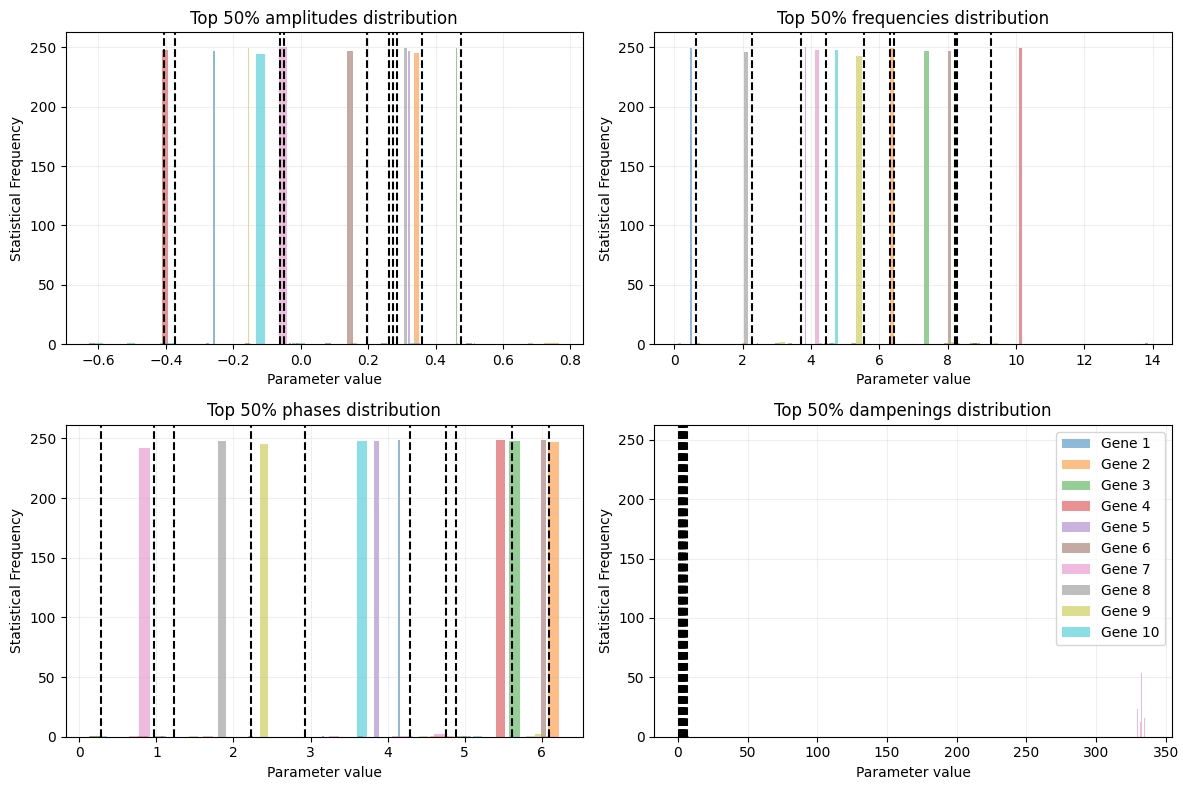

In [12]:
# population_params_history = np.asarray(population_params_history)
last_gen_params = population_params_history[-1]
last_gen_params_sorted = last_gen_params[:, last_gen_sorted, :]

# Top 50% individuals (highest fitness are at the end)
top_half_start = last_gen_params_sorted.shape[1] // 2
top_half_params = last_gen_params_sorted[:, top_half_start:, :]

param_names = ["amplitudes", "frequencies", "phases", "dampenings"]

fig = plt.figure(figsize=(12, 8))
axs= []

for i, name in enumerate(param_names, start=1):
    axs.append(plt.subplot(2, 2, i))
    for j in np.arange(top_half_params.shape[-1]):
        plt.hist(top_half_params[i-1,:,j], bins=40, alpha=0.5, color=f'C{j}', label=f'Gene {j+1}')
    plt.ylabel("Statistical Frequency")

    plt.title(f"Top 50% {name} distribution")
    plt.xlabel("Parameter value")
    
    plt.grid(alpha=0.2)

for j in np.arange(top_half_params.shape[-1]):
    axs[0].axvline(sin_coeffs[j], c= 'k', ls='--')

for j in np.arange(top_half_params.shape[-1]):
    axs[1].axvline(sin_freqs[j], c= 'k', ls='--')

for j in np.arange(top_half_params.shape[-1]):
    axs[2].axvline(sin_phases[j], c= 'k', ls='--')

for j in np.arange(top_half_params.shape[-1]):
    axs[3].axvline(dampening_coeffs[j], c= 'k', ls='--')
# sin_coeffs
    
plt.legend()
plt.tight_layout()